# Assignment 5: Neural coding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from scipy.optimize import minimize


In [2]:
%matplotlib inline

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['figure.figsize'] = [11, 5]


# Background

This assignment introduces the basic analysis techniques to investigate **how information entering the senses is transformed into a representation in the brain**. For example, while reading these words on a display, photons are hitting your retina which then converts them into nerve impulses that are eventually processed in the brain to make sense of the words. Similar principles apply when listening to music (where nerve impulses are generated by receptors in the cochlea in response to changes in sound pressure) and sensing the structure of a surface with a finger. All senses involve transformations of the signals from the sensory receptors into neural representations that are eventually useful for cognition and behavior.

A huge advantage of the sensory system, at least at early stages, is that we can try to understand the nature of the underlying transformations by regarding it as an **input-output function: sensory stimuli** (such as images that are presented to an animal on a computer screen) **are transformed into a neural response** (that can be measured in the same animal, e.g., in the visual cortex). This basic principle is associated with many different terms, including neural system characterization (Hunter & Korenberg, Biol Cybern (1986), receptive field estimation (Theunissen et al., J Neurosci 2000), white noise analysis (Chichilnisky, Network (2001)), spike-triggered average (de Boer & Kuyper, IEEE Transact Biomed Eng (1968), or reverse correlation (Ringach et al., Vis Res (1997)).

While many of these terms refer to the same principle, the underlying **neuronal stimulus-response functions (SRFs)** and the assumptions of different **estimators to find the parameters of these functions** can differ substantially. Together with Ross Williamson, Jennifer Linden and Maneesh Sahani, I have recently written a review that unifies many of the techniques in a way that is accessible to readers from outside the field ([Meyer et al., Front Systems Neurosci (2017)](https://www.frontiersin.org/articles/10.3389/fnsys.2016.00109/full)). This assignment is based on the concepts discussed in the review and uses the same terminology/notation. However, there are other highly recommended overviews, e.g., [Sharpee, Ann Rev Neurosci (2013)](https://papers.cnl-t.salk.edu/PDFs/Computational%20Identification%20of%20Receptive%20Fields%202013-4183.pdf).




# Stimulus-response functions: model-based characterization of sensory coding

## The "naive" approach

A major challenge with characterizing neural responses to sensory stimuli is that the possible space of inputs is very large (actually: infinite). An example from the auditory field might help to illustrate the problem. Imagine that you have a piano with 88 keys and you want to understand how a neuron in the auditory cortex is processing sounds (here: the tones that are generated when pressing one or more piano keys). All sensory neurons are more or less nonlinear. Thus the neural response to the combination of keys C1 and E1 is not the same as the sum of C1 or E1 when presented alone. As a consequence, probing the neuron with all possible key combinations would require $2^{88} - 1$ "stimuli". Even if we fix the duration of each stimulus to 1 second and use the same sound level this would exceed the lifetime of any species used to study these principles in the laboratory. Thus, we have to do something smarter.


## A better approach: the linear-nonlinear cascades

![](images/fig1.jpg)

An alternative approach is to use a statistical model that seeks to characterize response to complex stimuli. The hope is that complex stimuli contain a large number of different patterns that, on average, represent a reasonable approximation to the stimulus patterns that a neuron could "see" or "hear".

The most popular type of model is the so-called linear-nonlinear (LN) cascade model. The LN model is a cascade of two stages: 

#### 1. Linear Stage

The **linear stage** consists of one or more **linear filters** represented by the vectors $\mathbf{k}_1, \mathbf{k}_2, ...$ that describes how a neuron is integrating stimulus features (defined below). In this assignment we will focus on models with a single filter $\mathbf{k}$. The linear filters are invariable linked to the concept of a **receptive field (RF)**. Indeed, both terms are used interchangeably. Broadly speaking, the RF is a portion of **sensory space** that can elicit neuronal responses when stimulated. For example, a neuron in the visual cortex that elicits an action potential when an object appears in the upper left visual field is said to have a RF at that location. For a visual neuron, the sensory space is typically 2-dimensional (e.g., a x/y positions of pixels on a display used in laboratory settings) or 3-dimensional (e.g., pixel x/y positions that change over time). The precise geometry of the sensory space does often not matter. Instead, we treat every "element" (e.g., a pixel of an image) of this space as a single dimension in a usually high-dimensional "feature" space (see above image) and write the stimulus as a vector 

$$
\mathbf{s} = (s_1, s_2, s_3, ..., s_D)^T.
$$

The output of the linear stage is simply the dot product of the linear filter and the stimulus:

$$
x = \mathbf{k}^T \mathbf{s} = \sum_{i=1}^D k_i s_i.
$$

Thus, the entries in the vector $\mathbf{k}$ can be interpreted as the weights that a neuron gives to different stimulus features. For the visual neuron mentioned above, the weights would be non-zero for a pixel values in the upper left visual field, and zero otherwise. It is exactly this **simple interpretation of model parameters in the original stimulus space** that makes the LN cascade model so appealing and is one or the main reasons why it is extremely popular in neural coding. Moreover, as the dot product $\mathbf{k}^T\mathbf{s}$ maps the high-dim. stimulus to 1-dimensional neural response this stage is also often refered to as **dimensionality reduction**.


#### 2. Nonlinear Stage

The nonlinear stage that transforms the linearly filtered stimulus $x$ into a spike rate using a static, memoryless nonlinearity $f$. Thus, the output of the nonlinear stage for a single filter is given by $f(\mathbf{k}^T\mathbf{s})$. For dynamically fluctuating stimuli, the time-varying output of the LN model can simply be described by $f(\mathbf{k}^T\mathbf{s}_t)$ where $\mathbf{s}_t$ is the stimulus at discrete time step $t$.

There are a number of popular models that all use a linear inputs stage but are associated with different nonlinear stages:

![](images/fig2.jpg)

In this assignment, we will discuss the linear-Gaussian model and the linear-nonlinear Poisson model.


## The linear-Gaussian model

In the simplest case the response is assumed to be modeled directly by the output of a single filter, possibly with a constant offset response:

$$
    r_t = \mathbf{k}^T \mathbf{s}_t + r_0 + \mathcal{N}(0, \sigma^2)
$$

where response variability (which inevatibly arises in neural data) is Gaussian-distributed with constant variance $\sigma^2$ around the filter output. The constant offset term $r_0$ can be conveniently absorbed into the RF vector $\mathbf{k}$ by setting an additional dimension in the stimulus vector $\mathbf{s}_t$ to 1 at all times, so that the offset becomes the coefficient associated with this added dimension. Thus, we will typically omit explicit reference to (and notation of) the offset term.

Given a stimulus and a measured response, estimated filter weights $\hat{\mathbf{k}}$ can be obtained by minimizing the squared difference between the model output and the measured data:

\begin{equation}
\hat{\mathbf{k}} = \underset{k}{\mathrm{argmin}} \sum_{t=1}^{N} || r_t - \mathbf{k}^T \mathbf{s}_t||^2 = (\mathbf{S}^T\mathbf{S})^{-1}\mathbf{S}^T\mathbf{r}
\end{equation}

where $\mathbf{S}$ is the stimulus design matrix formed by collecting the stimulus vectors as rows, $\mathbf{S} = (\mathbf{s}_1, \mathbf{s}_2, ..., \mathbf{s}_N)^T$ and $\mathbf{r}$ is a column vector of corresponding measured responses. The matrix product $\mathbf{S}^T \mathbf{r}$ gives the sum of all stimuli that evoked spikes (with stimuli evoking multiple spikes repeated for each spike in the bin); if divided by the total number of spikes this would be the spike-triggered average (STA) stimulus. The term $\mathbf{S}^T \mathbf{S}$ is the stimulus auto-correlation matrix; pre-multiplying by its inverse removes any structure in the STA that might arise from correlations between different stimulus inputs, leaving an estimate of the RF filter. 

More generally, the above equations corresponds to the maximum likelihood estimator (MLE) for a model in which response variability is Gaussian-distributed with constant variance around the filter output $x_t$ (for details see the review paper mentioned above).

Before we start with the linear model, we define a number of helper functions to that are generally useful for data generation throughout the assignment:

In [3]:
def create_receptive_field(size=(15, 15),
                           mu=(8, 8),
                           sigma=(4, 4),
                           angle=45,
                           frequency=.085,
                           phase=0.):
    """2D Gabor-like receptive field
    
    Parameters
    ----------
    size: tuple
      (width, height) of the 2D RF
    mu: tuple
      (x, y) center coordinates of the Gaussian envelope
    sigma: tuple
      standard deviation of the Gaussian envelope
    angle: float
      Angle of the grating (in degrees)
    frequency: float
      Spatial grating frequency
    phase: float
      Spatial phase (in degrees)
    """

    xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

    # Gaussian envelope
    G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
               - np.power(yy - mu[1], 2) / (2. * sigma[1]))

    # spatial modulation
    phi = np.deg2rad(angle)
    xxr = xx * np.cos(phi)
    yyr = yy * np.sin(phi)
    xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
    S = np.cos(xyr + phase)

    K = G * S
    K /= np.amax(np.abs(K))

    return K


def create_gaussian_stimuli(n_bins, n_dim,
                            std_dev=1.,
                            append_ones=True):
    """Gausssian white noise stimulus matrix
    
    Parameter
    ---------
    n_bins: int
        Number of time steps
    n_dim: int
        RF dimensionality (= stimulus space dimensionality)
    std_dev: float
        Standard deviation of the Gaussian white noise
    append_ones: bool
        Append a column of ones to the stimulus matrix
    """

    S = std_dev * np.random.randn(n_bins, n_dim)

    if append_ones:
        # append a row with ones for fitting the offset term
        S = np.hstack((S, np.ones((n_bins, 1))))

    return S


The function `generate_data_linear` shows the single steps involved in generating (i.e. simulating) data using a linear-Gaussian model

In [4]:
def f_identity(x):
    # identity function used in a truly linear model

    return x


def f_threshold_quadratic(x):
    # threshold-quadratic nonlinearity

    y = np.copy(x)
    y[y < 0] = 0

    return y**2


def f_quadratic(x):
    # fully quadratic nonliearity

    return x**2


def generate_data_linear(rf_size=(15, 15),
                         f_nonlin=f_identity,
                         duration=10.,
                         dt=.1,
                         offset=2.,
                         noise_variance=4):
    """create model, stimulus set and and simulate neural response
    
    The model consists of the two stages:
    1. A 2-dimensional RF that is used to filter 2D Gaussian white noise stimuli
    2. A threshold-linear nonlinearity (as neural firing rates cannot be negative)

    Note: by using a large offset term (r_0) the model can be made linear as the product k x s will be 
    positive. However, for the chosen stimulus class (Gaussian white noise) the linear estimator provides 
    an unbiased estimate even in the presence of a nonlinearity (Bussgang Res. Lab. Elec. (1952), Paninski 
    Network (2003)).

    Parameters
    ----------
    duration: float
        Length of the data sequence in seconds
    f_nonlin: function-like
        The (potentially nonlinear) function that transforms k x s into a neural response (default: identity)
    dt: float
        Bin width (= time resolution) in seconds
    offset: float
        Offset term (see "r_0" in the description above)
    noise_variance: float
        Response noise variance
    """

    assert duration > 0 and dt > 0 and noise_variance >= 0

    # get number of non-overlapping time bins
    n_bins = int(round(duration / float(dt)))

    # Gabor-like receptive field
    K = create_receptive_field(size=rf_size)  # 2D RF -> matrix

    # append entry to "true" RF (ravel() vectorizes the 2D RF matrix into a 1D vector)
    k_with_offset = np.append(K.ravel(), offset)

    # generate Gaussian stimuli
    n_dim = K.size  # dimensionality of "vectorized" RF (= dim. of stimuli); the same as K.shape[0]*K.shape[1]
    S = create_gaussian_stimuli(n_bins, n_dim,
                                append_ones=True)

    # 1. linear stage
    ks = np.dot(k_with_offset, S.T)

    # 2. nonlinear stage (for a truly linear model: f -> identity function)
    rate = f_nonlin(ks)

    # add Gaussian noise centered around the "true" rate for each bin
    rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

    return K, S, ks, rate


Plot model parameters together with the generated neural response

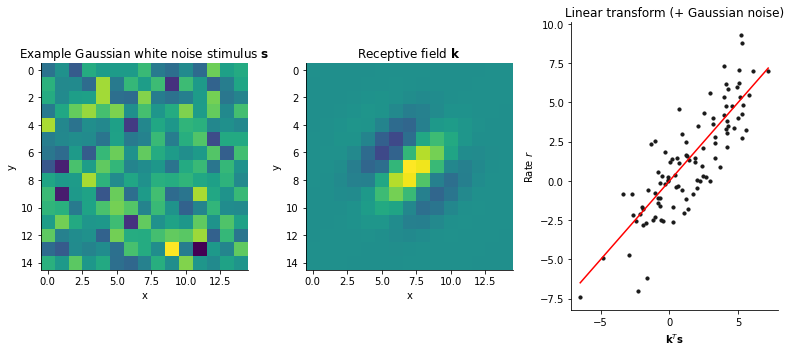

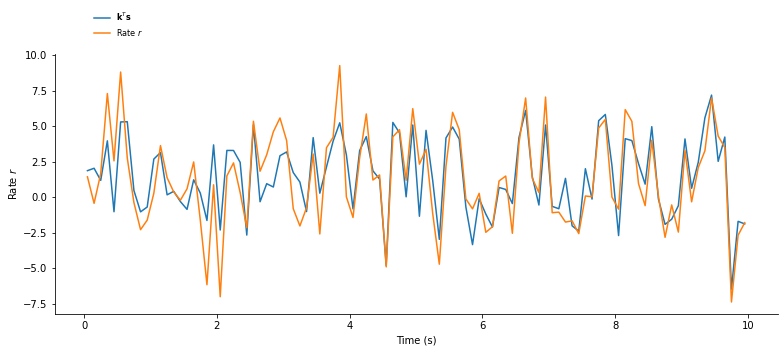

In [5]:
# simulate data
duration = 10.
dt = .1
f_nonlin = f_identity  # for a linear model
K_true, S, ks, rate = generate_data_linear(f_nonlin=f_nonlin,
                                           duration=duration,
                                           dt=dt)

# show example stimulus, receptive field, and static nonlinearity
fig, axes = plt.subplots(nrows=1, ncols=3)

ax = axes[0]
ax.set_title(r'Example Gaussian white noise stimulus $\mathbf{s}$')
ax.imshow(S[0, :-1].reshape(K_true.shape))
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = axes[1]
ax.set_title(r'Receptive field $\mathbf{k}$')
ax.imshow(K_true, vmin=-1, vmax=1)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = axes[2]
ax.set_title('Linear transform (+ Gaussian noise)')
xx = np.linspace(ks.min(), ks.max(), 100)
ax.plot(xx, f_nonlin(xx), 'r-')
ax.scatter(ks, rate, s=10, c=[3*[.1]])
ax.set_xlabel(r'$\mathbf{k}^T \mathbf{s}$')
ax.set_ylabel(r'Rate $r$')

fig.tight_layout()

# plot spike rate together with spikes
fig, ax = plt.subplots()

n_bins = len(rate)
t = (.5 + np.arange(n_bins)) * dt # show bin centers
ax.plot(t, ks, '-',
        color='tab:blue',
       label=r'$\mathbf{k}^T\mathbf{s}$')
ax.plot(t, rate, '-',
       color='tab:orange',
       label=r'Rate $r$')

ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Rate $r$')
ax.legend(loc=(.05, 1.05),
         fontsize=8).get_frame().set_visible(0)

fig.tight_layout()

## Exercise: estimation of model parameters for a linear-Gaussian model


Now it's your turn:

1. Simulate data using the function `generate_data_linear` for a duration of 100 s and estimate $\mathbf{k}$ using the linear estimator $\hat{\mathbf{k}} = (\mathbf{S}^T\mathbf{S})^{-1}\mathbf{S}^T\mathbf{r}$. Verify your implementation by plotting both the "true" linear filter used for the simulation and the estimated linear filter $\hat{\mathbf{k}}$. Hint: the pseudoinverse (`np.linalg.pinv`) is numerically more robust than the inverse (`np.linalg.inv`) for computing the inverse of the stimulus autocorrelation matrix.


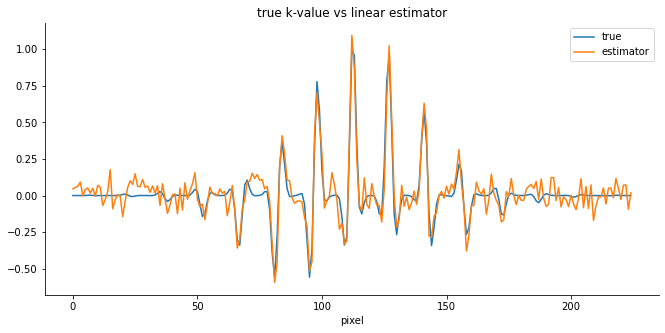

In [6]:
K, S, ks, rate = generate_data_linear(duration=100) # K[15,15] is receptive field, S[1000,15^2+1] is stimulus with extra +1 for offset, ks[1000] is approx matmul(K,S) so without noise, rate[1000] is actual rate in the end with noise
k_true = K.reshape(K.shape[0]**2)
k_est = np.matmul(np.linalg.pinv(np.matmul(np.transpose(S),S)), np.matmul(np.transpose(S),rate))[:K.shape[0]**2]

plt.figure()
plt.plot(k_true,label='true')
plt.plot(k_est,label='estimator')
plt.xlabel('pixel')
plt.title('true k-value vs linear estimator')
plt.legend()



2. Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF?


100%|██████████| 8/8 [00:02<00:00,  3.80it/s]


Text(0.5, 1.0, 'Pearson correlation between true and estimated RFs for different durations')

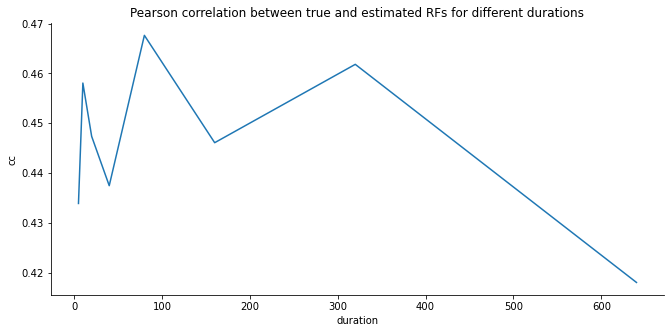

In [7]:
durations = [5,10,20,40,80,160,320,640]
trials = 10 
cc = np.zeros([len(durations),trials]) 

for i,sec in enumerate(tqdm(durations)): 
    for j in range(trials): 
        K, S, ks, rate = generate_data_linear(duration=duration) 
        k_true = K.reshape(K.shape[0]**2) 
        k_est = np.matmul(np.linalg.pinv(np.matmul(np.transpose(S),S)), np.matmul(np.transpose(S),rate))[:K.shape[0]**2] 
        cc[i,j] = np.dot(k_true,k_est)/(np.linalg.norm(k_true)*np.linalg.norm(k_est)) 

plt.figure()
plt.plot(durations,np.mean(cc,axis=1))
plt.xlabel('duration')
plt.ylabel('cc')
plt.title('Pearson correlation between true and estimated RFs for different durations')



3. Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.


100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Text(0.5, 1.0, 'Pearson correlation between true and estimated RFs for different noise')

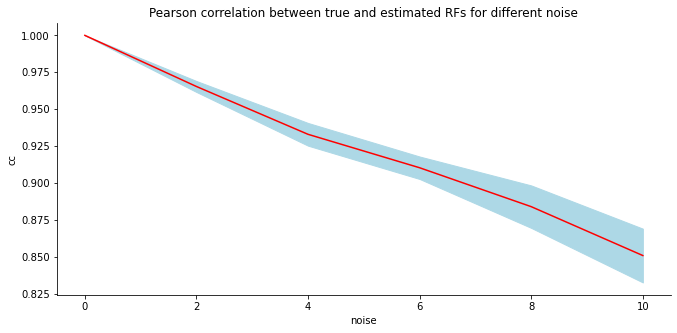

In [8]:

noise_levels = np.array([0,2,4,6,8,10])
trials = 10 
cc = np.zeros([len(noise_levels),trials]) 

for i,noise in enumerate(tqdm(noise_levels)): 
    for j in range(trials): 
        K, S, ks, rate = generate_data_linear(duration=100,noise_variance=noise) 
        k_true = K.reshape(K.shape[0]**2) 
        k_est = np.matmul(np.linalg.pinv(np.matmul(np.transpose(S),S)), np.matmul(np.transpose(S),rate))[:K.shape[0]**2] 
        cc[i,j] = np.dot(k_true,k_est)/(np.linalg.norm(k_true)*np.linalg.norm(k_est)) 

plt.figure()
plt.plot(noise_levels,np.mean(cc,axis=1),color='red')
plt.fill_between(noise_levels,np.mean(cc,axis=1)-np.std(cc,axis=1),np.mean(cc,axis=1)+np.std(cc,axis=1),color='lightblue')
plt.xlabel('noise')
plt.ylabel('cc')
plt.title('Pearson correlation between true and estimated RFs for different noise')



**Optional question (not mandatory):** What happens if the neural response is related to the filtered stimulus by a nonlinear function  $r = f_\mathrm{nonlinear}(\mathbf{k}^T \mathbf{s})$, e.g., by setting the `f_nonlin` argument in the data generation function to `f_threshold_quadratic` in excercise 1? Why does the linear estimator still provide a reliable estimate of the true RF? What happens if you use a full quadratic nonlinearity and set the `offset` term to 0? For more details, see Sharpee Ann Rev Neurosci (2013) (link in "Background" section).

## The linear-nonlinear Poisson (LNP) model

For spike-train responses, a natural first assumption is that spike times are influenced only by the stimulus, and are otherwise entirely independent of one another. This assumption requires that the distribution of spike times be governed by a **Poisson (point) process conditioned on the stimulus**, defined by an **instantaneous rate function**

$$
    \lambda_t = f(\mathbf{k}^T \mathbf{s}_t)
$$ 

(often also called intensity function). In turn, this means that the distributions of counts within response time bins of size $\Delta$ must follow a Poisson distribution

\begin{equation}
  P(r_t | \mathbf{s}_t, \mathbf{k}) = \frac{(\lambda_t\Delta)^{r_t}}{r_t!} e^{-\lambda_t\Delta}
\end{equation}

where $\lambda_t\Delta$ is the expected number of spikes in a small unit of time $\Delta$ and $\lambda_t$ is the rate (or intensity) of the Poisson process. As for the linear-Gaussian model, a constant offset term $r_0$ can be conveniently absorbed into the RF vector $\mathbf{k}$ by setting an additional dimension in the stimulus vector $\mathbf{s}_t$ to 1 at all times.

If $f$ is assumed to be monotonic and fixed (rather than being defined by parameters that must be fit along with the RF) then the above equation describes an instance of a **generalized linear model (GLM)** (Nelder and Wedderburn, 1972), a widely-studied class of regression models. Many common choices of $f$ result in a likelihood which is a concave function (Paninski, 2004), guaranteeing the existence of a **single optimum** that can easily be found by standard optimization techniques such as gradient ascent or Newton's method. The GLM formulation can also be extended to non-Poisson processes, by including probabilistic interactions between spikes in different bins that may be often reminiscent of cellular biophysical processes. However, here we will focus on a Poisson GLM without spike bin interactions.


average spike rate: 4.50 spikes per second


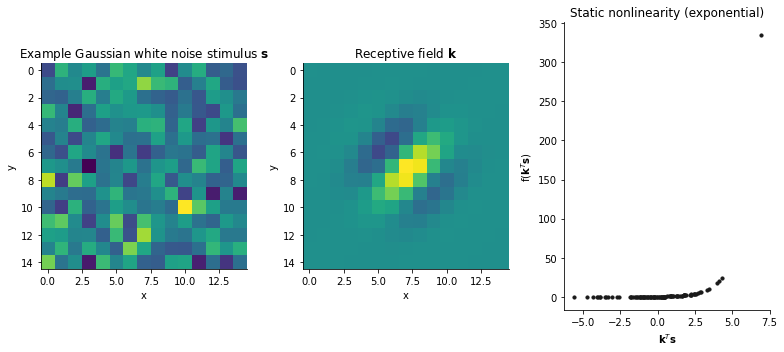

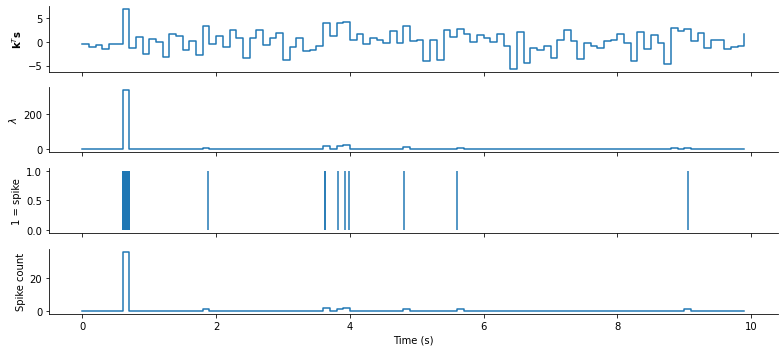

In [9]:
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)


def generate_data_poisson(rf_size=(15, 15),
                          duration=10.,
                          dt=.1,  # delta in equation
                          offset=0.,
                          spike_rate=5.  # average spike rate
                          ):

    assert duration > 0 and dt > 0

    # get number of non-overlapping time bins
    n_bins = round(duration / float(dt))

    # Gabor-like receptive field
    K = create_receptive_field(size=rf_size)  # 2D RF -> matrix

    # generate Gaussian stimuli
    n_dim = K.size  # dimensionality of "vectorized" RF (= dim. of stimuli); the same as K.shape[0]*K.shape[1]
    S = create_gaussian_stimuli(n_bins, n_dim,
                                std_dev=.75,  # gives a more realistic spike rate (exp() nonlinearity can produce very large values)
                                append_ones=True)

    # append entry to "true" RF (ravel() vectorizes the 2D RF matrix)
    k_with_offset = np.append(K.ravel(), offset)

    # 1. linear stage
    ks = np.dot(k_with_offset, S.T)

    # 2. nonlinear stage
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]

    print("average spike rate: %0.2f spikes per second" % (len(spike_times) / duration))

    return K, S, ks, lamda, spike_times, spike_counts


# show model parameters
duration = 10.
dt = .1
K_true, S, ks, lamda, spike_times, spike_counts = generate_data_poisson(duration=duration,
                                                                        dt=dt)


# show example stimulus, receptive field, and static nonlinearity
fig, axes = plt.subplots(nrows=1, ncols=3)

ax = axes[0]
ax.set_title(r'Example Gaussian white noise stimulus $\mathbf{s}$')
ax.imshow(S[0, :-1].reshape(K_true.shape))
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = axes[1]
ax.set_title(r'Receptive field $\mathbf{k}$')
ax.imshow(K_true, vmin=-1, vmax=1)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = axes[2]
ax.set_title('Static nonlinearity (exponential)')
ax.scatter(ks, lamda, s=10, c=[3*[.1]])
ax.set_xlabel(r'$\mathbf{k}^T \mathbf{s}$')
ax.set_ylabel(r'f($\mathbf{k}^T \mathbf{s})$')


fig.tight_layout()

# Show response
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

n_bins = lamda.shape[0]
t = np.arange(n_bins) * dt

ax1.step(t, ks, where='post')
ax1.set_ylabel(r'$\mathbf{k}^T \mathbf{s}$')

ax2.step(t, lamda, where='post')
ax2.set_ylabel(r'$\lambda$')

ax3.vlines(spike_times, 0, 1)
ax3.set_ylabel('1 = spike')

ax4.step(t, spike_counts, where='post')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike count')

fig.tight_layout()


### Excercises
The log-likelihood function and its derivative w.r.t $\mathbf{k}$ for a LNP model with exponential nonlinearity $f(\mathbf{k}^T \mathbf{s}) \equiv e^{\mathbf{k}^T \mathbf{s}}$ can be computed as follows: 
  
Log-likelihood for a single observation (at time $t$):

\begin{equation}
    \log P(r_t | \lambda_t) = r_t\log \lambda_t + r_t\log \Delta - \log r_t! - \lambda_t \Delta.
\end{equation}

Thus the log-likelihood for the whole spike sequence is given by

\begin{equation}
    \log P(R | \lambda) = \sum_t r_t\log \lambda_t + \sum_t r_t\log \Delta - \sum_t \log r_t! - \sum_t \lambda_t \Delta.
\end{equation}

The derivative w.r.t to $\mathbf{k}$ is

\begin{align}
    \frac{\partial{\log P}}{\partial{\mathbf{k}}} &= \sum_t \frac{\partial{r_t \log \lambda_t}}{\partial{\mathbf{k}}} + \sum_t \frac{\partial{r_t \log \Delta}}{\partial{\mathbf{k}}} - \sum_t \frac{\partial{r_t \log r_t!}}{\partial{\mathbf{k}}} - \Delta \sum_t \frac{\partial{\lambda_t}}{\partial{\mathbf{k}}} \\
    &= \sum_t \frac{\partial{r_t \log \lambda_t}}{\partial{\mathbf{k}}} - \Delta \sum_t \frac{\partial{\lambda_t}}{\partial{\mathbf{k}}}
\end{align}

and with $\frac{\partial{\lambda_t}}{\partial{\mathbf{k}}} = \mathbf{s}\lambda_t$

\begin{equation}
\frac{\partial{\log P}}{\partial{\mathbf{k}}} = \sum_t r_t \mathbf{s}_t - \Delta \sum_t \mathbf{s}_t \lambda_t
\end{equation}

Where the gradient is given as

\begin{equation}
\frac{\partial^2{\log P}}{\partial{\mathbf{k}}^2} = - \Delta \sum_t \mathbf{s}_t^2 \lambda_t
\end{equation}


  
  Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 


4. Fit the model to some simulated data (duration = 100 s). For the exponential nonlinearity, the log-likelihood is a concave function. Thus, the parameters can be found using gradient descent. The scipy package provides the [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function that can be used to **minimize the  negative log-likelihood** (which is equivalent to maximizing the log-likelihood). The minimize function supports a number of algorithms. As we can explicitly compute the gradient for this type of LNP model, algorithms that make use of the gradient are prefered as they are particularly fast, e.g., `method='Newton-CG'`. The function to compute the gradient need to be passed to the minimize method as a keyword agument: `jac=my_gradient_function`. Initialize the RF parameters using the spike-triggered average (STA)
$$
 k_\mathrm{STA} = \frac{\mathbf{S}^T \mathbf{r}}{n_\mathrm{spikes}}
$$
where $n_\mathrm{spikes}$ is the total number of spikes in $\mathbf{r}$. **Note:** the exponential nonlinearity is very sensitive to the scaling. To avoid numerical issues initialize the RF parameters with $\mathbf{k}_\mathrm{init} = \frac{\mathbf{k}_\mathrm{STA}}{10}$.

In [10]:
# lamda_est = np.exp(np.matmul(S,k_estim))
# dlogP_dk = np.matmul(np.transpose(S),spike_counts) - dt*np.matmul(np.transpose(S),lamda_est)
# minimize()

In [15]:
lamda.shape,   S.shape,   spike_counts.shape,   k_init.shape,   np.exp(np.matmul(S,k_init)).shape,   np.matmul(np.transpose(S),spike_counts-dt*lamda).shape

((1000,), (1000, 226), (1000,), (226,), (1000,), (226,))

In [27]:
duration,dt = 100, 0.1
K_true, S, ks, lamda, spike_times, spike_counts = generate_data_poisson(duration=duration,dt=dt)
k_STA = np.matmul(S.T,spike_counts)/np.sum(spike_counts)
k_init = k_STA/1000

def dlogP_dk(k,S):
    """ Returns d(logP)/d(k) """
    lamda_estim = np.exp(np.matmul(S,k))
    dlogP_dk = np.matmul(S.T,spike_counts-dt*lamda_estim)
    return -dlogP_dk

def gradient_descent(k,S):
    """ Returns the gradient of dlogP_dk at vec{k} given S """
    lamda_estim = np.exp(np.matmul(S,k))
    gradient = dt*np.matmul(S.T**2,lamda_estim)
    return -gradient

minimize(dlogP_dk,k_init,args=(S),method='Newton-CG',jac=gradient_descent)

dlogP_dk(k_init,S).shape, gradient_descent(k_init,S).shape

average spike rate: 4.61 spikes per second


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Exercise 4 (optional): spectro-temporal receptive fields estimation

![images/fig1_auditory_example.png](images/fig1_auditory_example.png)

The goal of this optional excercise is to apply the above estimators to real data measured in the auditory cortex (ACx) in awake behaving mice. The stimulus is described by the spectrogram of a sound as shown in the above image. In particular, the response in time bin $t$ (red rectangle) is assumed to only depend on the most recent stimulus history preceding the response (blue rectangle). As a consequence, the stimulus space consists of the elements of the spectro-temporal pattern preceding the response: the spectral part describes the power in the different frequency channels and the temporal part how the power is dynamically changing. The corresponding RF is often called spectro-temporal receptive field (STRF).

The stimulus used for the recording is a statistically stationary, spectrotemporally rich, dynamic random chord (DRC) stimulus. Think of it as pressing random key combinations on a piano keyboard (about 5 keys at the same time) but adapted to the temporal (duration 20 ms per chord) and spectral characteristics (5 -- 40 kHz) of the mouse's auditory system. To allow estimation of the spike rate (e.g., as useful for the linear model), the whole stimulus (60 s) was presented 10 times (trials) resulting in 10 spike trains.


### Exercises

5. Create a stimulus matrix $\mathbf{S}$ from the stimulus spectrogram by rearranging the stimulus history (blue rectangle) as vector $\mathbf{s}$ for each time step. The duration of each chord is 20 ms and the typical history length used for ACx neurons is 240 ms. Moreover, compute the average spike count for each 20 ms bin from the spikes trains obtained for repeated stimulus presentations. Drop the first few spike count bins that have an incomplete stimulus history, i.e. the spike count bins for which the blue rectangle exceeds the spectrogram towards the left side in the above image.
6. Estimate the STRF using a linear model and the Poisson model implemented in the previous excercises. Describe to what part of the stimulus space (here: time lag and frequency channel) the neuron is sensitive to.

Spectrogram: 3000 time bins x 36 frequency channels
Time resolution of each bin: 0.020 seconds
Total stimulus duration: 60.0 seconds
# of stimulus presentations: 10 trials


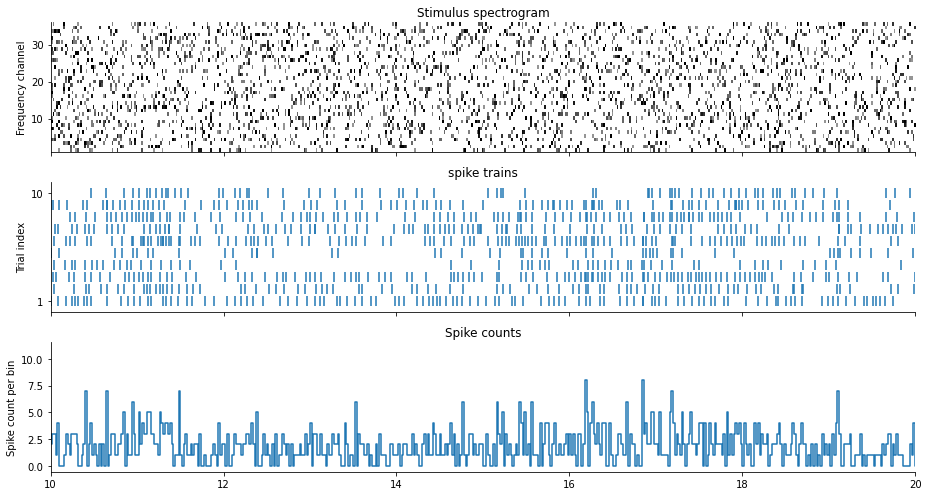

In [ ]:
# load and show data
import os.path as op

data = np.load(op.join(_dh[0], 'example_cell_ACx.npy'),
               allow_pickle=True).item()

spectrogram = data['spectrogram']
dt = data['dt']
spikes_trials = data['spikes_trials']
n_trials = len(spikes_trials)

print("Spectrogram: %d time bins x %d frequency channels" % spectrogram.shape)
print("Time resolution of each bin: %0.3f seconds" % dt)
print("Total stimulus duration: %0.1f seconds" % (spectrogram.shape[0] * dt))
print("# of stimulus presentations: %d trials" % (n_trials))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,
                                    ncols=1,
                                    sharex=True)

time_bins = np.arange(spectrogram.shape[0]+1) * dt
spike_counts = np.histogram(np.concatenate(spikes_trials),
                            bins=time_bins)[0]

ax1.set_title('Stimulus spectrogram')
ax1.imshow(spectrogram.T,
           origin='lower',
           extent=(time_bins[0], time_bins[-1], 1, spectrogram.shape[1]),
           aspect='auto',
           interpolation='nearest',
           cmap='Greys')
ax1.set_ylabel('Frequency channel')

ax2.set_title('spike trains')
for i, ts in enumerate(spikes_trials):
    ax2.vlines(ts, ymin=.6+i, ymax=.6+i+.8)
ax2.set_ylabel('Trial index')
ax2.set_yticks([1, n_trials])

ax3.set_title('Spike counts')
ax3.step(time_bins[:-1], spike_counts, where='post')
ax3.set_ylabel('Spike count per bin')

ax3.set_xlim(10, 20)  # changes this if you want "zoom in" or "zoom out" in time

fig.set_size_inches(13, 7)
fig.tight_layout()
